**Sexto Trabalho**

**Nome:Valéria Cristina A. R. de Figueredo**

In [17]:
# Importando as bibliotecas necessárias
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

In [18]:
# Download do dataset MNIST into data dir
! wget https://pjreddie.com/media/files/mnist_train.csv -P data

--2024-12-15 22:28:57--  https://pjreddie.com/media/files/mnist_train.csv
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109575994 (104M) [text/csv]
Saving to: ‘data/mnist_train.csv’

mnist_train.csv     100%[===================>] 104.50M  15.9MB/s    in 6.8s    

2024-12-15 22:29:05 (15.4 MB/s) - ‘data/mnist_train.csv’ saved [109575994/109575994]



In [19]:
class MNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file, header=None)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # A primeira coluna é o rótulo
        label = self.data.iloc[idx, 0]
        # As demais colunas são os pixels da imagem
        image = self.data.iloc[idx, 1:].values.astype('uint8').reshape(28, 28)

        if self.transform:
            image = self.transform(image)

        return image, label

In [20]:
# Transformação para converter a imagem para tensor
transform = transforms.Compose([
    transforms.ToTensor(),      # Convertendo a imagem PIL para tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalizando a imagem
])

# Criando o dataset
mnist_dataset = MNISTDataset("./data/mnist_train.csv", transform=transform)

# Transformação para converter a imagem para tensor
transform = transforms.Compose([
    transforms.ToPILImage(),    # Convertendo o array numpy para imagem PIL
    transforms.ToTensor(),      # Convertendo a imagem PIL para tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalizando a imagem
])

# Criando o dataset
mnist_dataset = MNISTDataset("./data/mnist_train.csv", transform=transform)

In [21]:
# Criando índices aleatórios para os subsets de treino e teste
np.random.seed(42)
indices = np.arange(len(mnist_dataset))
np.random.shuffle(indices)

# Dividindo os índices em trainset e testset
num_train = 1000
num_val = 500
num_test = 500
train_indices = indices[:num_train]  # Primeiros 1.000 índices para o trainset
val_indices = indices[num_train:num_train+num_val]  # Próximos 500 índices para o valset
test_indices = indices[num_train+num_val:num_train+num_val+num_test]  # Mais 500 para o testset

trainset = Subset(mnist_dataset, train_indices)
valset = Subset(mnist_dataset, val_indices)
testset = Subset(mnist_dataset, test_indices)

# Criando DataLoaders para os subsets
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

In [22]:
def train_model(model, trainloader, valloader, criterion, optimizer, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')

        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def test_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')

In [23]:
class CNN(nn.Module):
    def __init__(self, initialize_weights=True, dropout=0.2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 12, 5)
        self.fc1 = nn.Linear(12 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(dropout)

        if initialize_weights:
            self._initialize_weights()

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten
        x = x.view(-1, 12 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

In [24]:
model = CNN(
    initialize_weights=True,
    dropout=0.2
)


In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [26]:
# Treinando a CNN
history = train_model(
    model=model,
    trainloader=trainloader,
    valloader=valloader,
    criterion=criterion,
    optimizer=optimizer
)

100%|██████████| 16/16 [00:01<00:00, 11.45it/s]


Epoch 1, Train Loss: 2.328, Train Accuracy: 13.30%
Epoch 1, Val Loss: 2.235, Val Accuracy: 21.20%


100%|██████████| 16/16 [00:01<00:00, 15.66it/s]


Epoch 2, Train Loss: 2.100, Train Accuracy: 29.20%
Epoch 2, Val Loss: 1.850, Val Accuracy: 42.60%


100%|██████████| 16/16 [00:00<00:00, 19.57it/s]


Epoch 3, Train Loss: 1.474, Train Accuracy: 51.70%
Epoch 3, Val Loss: 0.943, Val Accuracy: 71.40%


100%|██████████| 16/16 [00:00<00:00, 22.71it/s]


Epoch 4, Train Loss: 0.905, Train Accuracy: 69.20%
Epoch 4, Val Loss: 0.589, Val Accuracy: 82.40%


100%|██████████| 16/16 [00:00<00:00, 21.98it/s]


Epoch 5, Train Loss: 0.604, Train Accuracy: 80.00%
Epoch 5, Val Loss: 0.453, Val Accuracy: 85.40%
Treinamento concluído


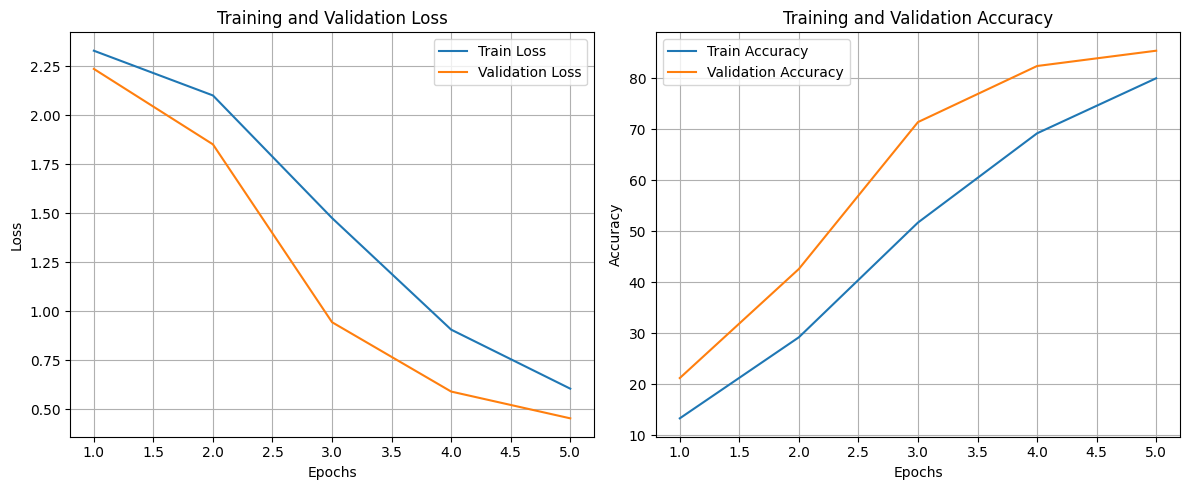

In [27]:
epochs = range(1, len(history['train_losses']) + 1)

# Plot de losses
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.grid()
plt.plot(epochs, history['train_losses'], label='Train Loss')
plt.plot(epochs, history['val_losses'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot de accuracies
plt.subplot(1, 2, 2)
plt.grid()
plt.plot(epochs, history['train_accuracies'], label='Train Accuracy')
plt.plot(epochs, history['val_accuracies'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [28]:
test_model(model, testloader)

Acurácia da rede na base de teste: 89.20%


## Exercícios

### Exercício 1
Na CNN implementada, execute experimentos variando:
- O número de filtros convolucionais em `self.conv1` (6 e 8)
- O número de filtros convolucionais em `self.conv2` (12 e 16)

Ao final, observe qual combinação desempenha melhor no conjunto de testes.

Dica: Adicionar argumentos no construtor da classe para determinar o número de filtros em cada camada pode ser útil para inicializar diversos modelos.

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Definição da CNN class
class CNN(nn.Module):
    def __init__(self, initialize_weights=True, dropout=0.2, num_filters_1=6, num_filters_2=12):
        super(CNN, self).__init__()
        self.num_filters_2 = num_filters_2
        self.conv1 = nn.Conv2d(1, num_filters_1, 5)
        self.conv2 = nn.Conv2d(num_filters_1, num_filters_2, 5)
        self.fc1 = nn.Linear(num_filters_2 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(dropout)

        if initialize_weights:
            self._initialize_weights()

    def forward(self, x):
        # Camadas de CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten e Conecção de camadas
        x = x.view(-1, self.num_filters_2 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

# Lista de combinação de filtros
parameters_combinations = [
    (6, 12),
    (6, 16),
    (8, 12),
    (6, 16),
]

# Loop pelos filtros e treino do modelo
for num_filters_1, num_filters_2 in parameters_combinations:
    print(f'Testing model with num_filters_1={num_filters_1} and num_filters_2={num_filters_2}')

    model = CNN(
        initialize_weights=True,
        dropout=0.2,
        num_filters_1=num_filters_1,
        num_filters_2=num_filters_2
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    # Treino do modelo
    history = train_model(
        model=model,
        trainloader=trainloader,
        valloader=valloader,
        criterion=criterion,
        optimizer=optimizer
    )

    # Teste do modelo
    test_model(model, testloader)
    print()

Testing model with num_filters_1=6 and num_filters_2=12


100%|██████████| 16/16 [00:00<00:00, 23.40it/s]


Epoch 1, Train Loss: 2.222, Train Accuracy: 22.20%
Epoch 1, Val Loss: 2.010, Val Accuracy: 48.20%


100%|██████████| 16/16 [00:00<00:00, 23.39it/s]


Epoch 2, Train Loss: 1.681, Train Accuracy: 48.30%
Epoch 2, Val Loss: 1.137, Val Accuracy: 65.60%


100%|██████████| 16/16 [00:00<00:00, 23.33it/s]


Epoch 3, Train Loss: 0.977, Train Accuracy: 67.40%
Epoch 3, Val Loss: 0.650, Val Accuracy: 80.20%


100%|██████████| 16/16 [00:00<00:00, 23.51it/s]


Epoch 4, Train Loss: 0.593, Train Accuracy: 80.40%
Epoch 4, Val Loss: 0.417, Val Accuracy: 87.60%


100%|██████████| 16/16 [00:00<00:00, 23.87it/s]


Epoch 5, Train Loss: 0.450, Train Accuracy: 83.70%
Epoch 5, Val Loss: 0.325, Val Accuracy: 90.20%
Treinamento concluído
Acurácia da rede na base de teste: 89.00%

Testing model with num_filters_1=6 and num_filters_2=16


100%|██████████| 16/16 [00:00<00:00, 22.93it/s]


Epoch 1, Train Loss: 2.290, Train Accuracy: 12.60%
Epoch 1, Val Loss: 2.182, Val Accuracy: 23.60%


100%|██████████| 16/16 [00:00<00:00, 23.23it/s]


Epoch 2, Train Loss: 2.020, Train Accuracy: 28.90%
Epoch 2, Val Loss: 1.713, Val Accuracy: 47.20%


100%|██████████| 16/16 [00:00<00:00, 22.45it/s]


Epoch 3, Train Loss: 1.405, Train Accuracy: 54.10%
Epoch 3, Val Loss: 0.956, Val Accuracy: 66.20%


100%|██████████| 16/16 [00:00<00:00, 22.93it/s]


Epoch 4, Train Loss: 0.881, Train Accuracy: 70.50%
Epoch 4, Val Loss: 0.634, Val Accuracy: 81.00%


100%|██████████| 16/16 [00:00<00:00, 17.57it/s]


Epoch 5, Train Loss: 0.621, Train Accuracy: 78.80%
Epoch 5, Val Loss: 0.512, Val Accuracy: 83.60%
Treinamento concluído
Acurácia da rede na base de teste: 85.80%

Testing model with num_filters_1=8 and num_filters_2=12


100%|██████████| 16/16 [00:01<00:00, 15.59it/s]


Epoch 1, Train Loss: 2.255, Train Accuracy: 20.50%
Epoch 1, Val Loss: 2.127, Val Accuracy: 33.00%


100%|██████████| 16/16 [00:00<00:00, 16.87it/s]


Epoch 2, Train Loss: 1.838, Train Accuracy: 42.30%
Epoch 2, Val Loss: 1.349, Val Accuracy: 58.00%


100%|██████████| 16/16 [00:00<00:00, 22.20it/s]


Epoch 3, Train Loss: 1.103, Train Accuracy: 65.80%
Epoch 3, Val Loss: 0.733, Val Accuracy: 74.80%


100%|██████████| 16/16 [00:00<00:00, 22.68it/s]


Epoch 4, Train Loss: 0.719, Train Accuracy: 76.10%
Epoch 4, Val Loss: 0.539, Val Accuracy: 84.40%


100%|██████████| 16/16 [00:00<00:00, 20.44it/s]


Epoch 5, Train Loss: 0.575, Train Accuracy: 81.90%
Epoch 5, Val Loss: 0.460, Val Accuracy: 86.80%
Treinamento concluído
Acurácia da rede na base de teste: 89.80%

Testing model with num_filters_1=6 and num_filters_2=16


100%|██████████| 16/16 [00:00<00:00, 22.23it/s]


Epoch 1, Train Loss: 2.218, Train Accuracy: 21.70%
Epoch 1, Val Loss: 2.012, Val Accuracy: 37.60%


100%|██████████| 16/16 [00:00<00:00, 22.19it/s]


Epoch 2, Train Loss: 1.699, Train Accuracy: 44.20%
Epoch 2, Val Loss: 1.315, Val Accuracy: 57.60%


100%|██████████| 16/16 [00:00<00:00, 22.00it/s]


Epoch 3, Train Loss: 1.114, Train Accuracy: 63.80%
Epoch 3, Val Loss: 0.805, Val Accuracy: 75.20%


100%|██████████| 16/16 [00:00<00:00, 22.14it/s]


Epoch 4, Train Loss: 0.724, Train Accuracy: 74.30%
Epoch 4, Val Loss: 0.542, Val Accuracy: 83.40%


100%|██████████| 16/16 [00:00<00:00, 22.12it/s]


Epoch 5, Train Loss: 0.521, Train Accuracy: 82.90%
Epoch 5, Val Loss: 0.444, Val Accuracy: 85.40%
Treinamento concluído
Acurácia da rede na base de teste: 88.80%



### Exercício 2

Na CNN implementada, execute 5 treinamentos variando aleatoriamente o número de neurônios de saída em `self.fc1` (o valor atual é 64 e também deve ser alterado na entrada da próxima camada).

Como você determinaria qual foi o melhor valor?

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Definição da CNN class
class CNN(nn.Module):
    def __init__(self, initialize_weights=True, dropout=0.2, num_filters_1=6, num_filters_2=12, num_hidden=64):
        super(CNN, self).__init__()
        self.num_filters_2 = num_filters_2
        self.conv1 = nn.Conv2d(1, num_filters_1, 5)
        self.conv2 = nn.Conv2d(num_filters_1, num_filters_2, 5)
        self.fc1 = nn.Linear(num_filters_2 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(dropout)

        if initialize_weights:
            self._initialize_weights()

    def forward(self, x):
        # Camadas de CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten e Conecção de camadas
        x = x.view(-1, self.num_filters_2 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

for i in range(5):
    num_neurons = np.random.randint(10, 100)

    model = CNN(
        initialize_weights=True,
        dropout=0.2,
        num_hidden=num_neurons
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    # Treino do modelo CNN
    history = train_model(
        model=model,
        trainloader=trainloader,
        valloader=valloader,
        criterion=criterion,
        optimizer=optimizer
    )

    print(f'Número de neurônios na camada conectada: {num_neurons}')

    # Teste do modelo
    test_model(model, testloader)
    print()
    print()


100%|██████████| 16/16 [00:00<00:00, 17.68it/s]


Epoch 1, Train Loss: 2.304, Train Accuracy: 13.30%
Epoch 1, Val Loss: 2.236, Val Accuracy: 22.60%


100%|██████████| 16/16 [00:00<00:00, 23.01it/s]


Epoch 2, Train Loss: 2.138, Train Accuracy: 28.50%
Epoch 2, Val Loss: 1.960, Val Accuracy: 41.20%


100%|██████████| 16/16 [00:00<00:00, 22.99it/s]


Epoch 3, Train Loss: 1.599, Train Accuracy: 47.50%
Epoch 3, Val Loss: 1.075, Val Accuracy: 63.80%


100%|██████████| 16/16 [00:00<00:00, 23.11it/s]


Epoch 4, Train Loss: 0.850, Train Accuracy: 72.50%
Epoch 4, Val Loss: 0.535, Val Accuracy: 85.60%


100%|██████████| 16/16 [00:00<00:00, 22.88it/s]


Epoch 5, Train Loss: 0.549, Train Accuracy: 80.90%
Epoch 5, Val Loss: 0.412, Val Accuracy: 87.40%
Treinamento concluído
Número de neurônios na camada conectada: 31
Acurácia da rede na base de teste: 89.00%




100%|██████████| 16/16 [00:00<00:00, 22.00it/s]


Epoch 1, Train Loss: 2.279, Train Accuracy: 13.30%
Epoch 1, Val Loss: 2.191, Val Accuracy: 21.20%


100%|██████████| 16/16 [00:00<00:00, 21.75it/s]


Epoch 2, Train Loss: 2.022, Train Accuracy: 34.20%
Epoch 2, Val Loss: 1.617, Val Accuracy: 57.60%


100%|██████████| 16/16 [00:00<00:00, 22.99it/s]


Epoch 3, Train Loss: 1.190, Train Accuracy: 61.10%
Epoch 3, Val Loss: 0.655, Val Accuracy: 78.80%


100%|██████████| 16/16 [00:00<00:00, 22.27it/s]


Epoch 4, Train Loss: 0.662, Train Accuracy: 77.90%
Epoch 4, Val Loss: 0.429, Val Accuracy: 86.80%


100%|██████████| 16/16 [00:00<00:00, 22.56it/s]


Epoch 5, Train Loss: 0.433, Train Accuracy: 86.50%
Epoch 5, Val Loss: 0.382, Val Accuracy: 88.60%
Treinamento concluído
Número de neurônios na camada conectada: 76
Acurácia da rede na base de teste: 88.40%




100%|██████████| 16/16 [00:00<00:00, 16.87it/s]


Epoch 1, Train Loss: 2.309, Train Accuracy: 13.60%
Epoch 1, Val Loss: 2.224, Val Accuracy: 24.00%


100%|██████████| 16/16 [00:01<00:00, 15.26it/s]


Epoch 2, Train Loss: 2.086, Train Accuracy: 32.10%
Epoch 2, Val Loss: 1.801, Val Accuracy: 49.80%


100%|██████████| 16/16 [00:00<00:00, 20.78it/s]


Epoch 3, Train Loss: 1.507, Train Accuracy: 49.70%
Epoch 3, Val Loss: 1.058, Val Accuracy: 65.20%


100%|██████████| 16/16 [00:00<00:00, 23.36it/s]


Epoch 4, Train Loss: 0.992, Train Accuracy: 65.80%
Epoch 4, Val Loss: 0.715, Val Accuracy: 77.20%


100%|██████████| 16/16 [00:00<00:00, 23.78it/s]


Epoch 5, Train Loss: 0.629, Train Accuracy: 78.90%
Epoch 5, Val Loss: 0.555, Val Accuracy: 82.60%
Treinamento concluído
Número de neurônios na camada conectada: 44
Acurácia da rede na base de teste: 87.80%




100%|██████████| 16/16 [00:00<00:00, 22.90it/s]


Epoch 1, Train Loss: 2.242, Train Accuracy: 18.20%
Epoch 1, Val Loss: 2.109, Val Accuracy: 38.00%


100%|██████████| 16/16 [00:00<00:00, 22.94it/s]


Epoch 2, Train Loss: 1.840, Train Accuracy: 40.80%
Epoch 2, Val Loss: 1.338, Val Accuracy: 64.00%


100%|██████████| 16/16 [00:00<00:00, 22.58it/s]


Epoch 3, Train Loss: 1.179, Train Accuracy: 59.80%
Epoch 3, Val Loss: 0.791, Val Accuracy: 75.00%


100%|██████████| 16/16 [00:00<00:00, 23.12it/s]


Epoch 4, Train Loss: 0.774, Train Accuracy: 74.70%
Epoch 4, Val Loss: 0.524, Val Accuracy: 86.00%


100%|██████████| 16/16 [00:00<00:00, 22.68it/s]


Epoch 5, Train Loss: 0.502, Train Accuracy: 83.90%
Epoch 5, Val Loss: 0.433, Val Accuracy: 86.60%
Treinamento concluído
Número de neurônios na camada conectada: 41
Acurácia da rede na base de teste: 87.60%




100%|██████████| 16/16 [00:00<00:00, 23.11it/s]


Epoch 1, Train Loss: 2.284, Train Accuracy: 15.20%
Epoch 1, Val Loss: 2.217, Val Accuracy: 27.40%


100%|██████████| 16/16 [00:00<00:00, 22.83it/s]


Epoch 2, Train Loss: 2.060, Train Accuracy: 31.60%
Epoch 2, Val Loss: 1.771, Val Accuracy: 57.20%


100%|██████████| 16/16 [00:00<00:00, 16.71it/s]


Epoch 3, Train Loss: 1.377, Train Accuracy: 56.50%
Epoch 3, Val Loss: 0.857, Val Accuracy: 74.60%


100%|██████████| 16/16 [00:01<00:00, 15.29it/s]


Epoch 4, Train Loss: 0.754, Train Accuracy: 74.70%
Epoch 4, Val Loss: 0.570, Val Accuracy: 82.40%


100%|██████████| 16/16 [00:00<00:00, 20.36it/s]


Epoch 5, Train Loss: 0.496, Train Accuracy: 85.10%
Epoch 5, Val Loss: 0.456, Val Accuracy: 84.60%
Treinamento concluído
Número de neurônios na camada conectada: 47
Acurácia da rede na base de teste: 88.20%


